# FTP NOAA

In [13]:
from ftplib import FTP

with FTP("ftp.swpc.noaa.gov") as ftp:

    ftp.login()

    ftp.cwd("pub/forecasts/SRS/")
    
    file_list = ftp.nlst()
    
    readme_file = [filename for filename in file_list if filename.lower().startswith('readme')]
    
    if readme_file:
        # Retrieve contents of README file
        readme_contents = []
        ftp.retrlines('RETR ' + readme_file[0], readme_contents.append)
        
        # Print contents of README file
        print("Contents of README file in SRS folder:")
        for line in readme_contents:
            print(line)
    else:
        print("README file not found in SRS folder.")

Contents of README file in SRS folder:
January 3, 2008

                     Space Weather Prediction Center
                          SOLAR REGION SUMMARY (SRS)

  The Solar Region Summary (SRS), compiled by SWPC, is a daily report of 
  the active solar regions observed during the preceding day. The SRS
  contains a detailed description of the active regions currently visible
  on the solar disk. See sample and description below.

  The characteristics for each active region are compiled from up to six
  observatories that report to the SWPC in near-real time. The sunspot 
  counts are typically higher than those reported in non-real time by the
  Sunspot Index Data Center (SIDC), Brussels, Belgium, and the American 
  Association of Variable Star Observers.

The last 75 daily Solar Region Summary reports are included in this directory.
   Issue time:     Daily at 0030 UTC  It is usually on-line by 0040 UTC.
   Period covered: Previous UTC day.
  
Available:
  via SWPC Anonymous FTP 

## Get AR IDs

In [14]:
with FTP("ftp.swpc.noaa.gov") as ftp:
    ftp.login()
    
    # Retrieve contents of SRS.txt
    file_contents = []
    ftp.retrlines('RETR /pub/latest/SRS.txt', file_contents.append)
    
    # Print contents of SRS.txt
    print("Contents of SRS.txt:")
    for line in file_contents:
        print(line)

Contents of SRS.txt:
:Product: Solar Region Summary
:Issued: 2024 Apr 09 0030 UTC
# Prepared jointly by the U.S. Dept. of Commerce, NOAA,
# Space Weather Prediction Center and the U.S. Air Force.
#
Joint USAF/NOAA Solar Region Summary
SRS Number 100 Issued at 0030Z on 09 Apr 2024
Report compiled from data received at SWO on 08 Apr
I.  Regions with Sunspots.  Locations Valid at 08/2400Z 
Nmbr Location  Lo  Area  Z   LL   NN Mag Type
3628 N08W00   003  0260 Cho  05   05 Beta
3629 N06W69   072  0020 Cao  02   03 Beta
3631 N11W48   051  0010 Axx  01   01 Alpha
3632 N28E04   359  0010 Hsx  02   02 Alpha
3633 S07E44   319  0160 Dsi  08   06 Beta-Gamma
3634 N27E54   309  0010 Axx  02   02 Alpha
IA. H-alpha Plages without Spots.  Locations Valid at 08/2400Z Apr
Nmbr  Location  Lo
3624  N15W74   077
3627  N09W23   026
3630  S11W67   070
II. Regions Due to Return 09 Apr to 11 Apr
Nmbr Lat    Lo
3621 N17    270
3614 N16    240


### get I.

In [98]:
import re

with FTP("ftp.swpc.noaa.gov") as ftp:
    ftp.login()
    
    file_contents = []
    ftp.retrlines('RETR /pub/latest/SRS.txt', file_contents.append)

    sunspot_regions = []
    start_extraction = False
    for line in file_contents:
        
        if line.startswith("Nmbr"):
            start_extraction = True
            continue
                
        if start_extraction and line.startswith("I"):
            break
        
        
        if start_extraction:
            match = re.search(r'(\d{4})\s+([NS]\d+[EW]\d+)', line)
            if match:
                region_number = match.group(1)
                location = match.group(2)
                sunspot_regions.append((int(region_number), location))

In [99]:
sunspot_regions

[(3628, 'N08W00'),
 (3629, 'N06W69'),
 (3631, 'N11W48'),
 (3632, 'N28E04'),
 (3633, 'S07E44'),
 (3634, 'N27E54')]

In [100]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

from datetime import datetime

import matplotlib.pyplot as plt

date_str = '2024 Apr 09 0000 UTC'
date_obs = datetime.strptime(date_str, '%Y %b %d %H%M %Z')

for i in range(len(sunspot_regions)):
    region_number, coord_str = sunspot_regions[i]
    lat_str = coord_str[1:3]
    lon_str = coord_str[4:]
    lat_sign = 1 if coord_str[0] == 'N' else -1
    lon_sign = 1 if coord_str[3] == 'W' else -1
    latitude = lat_sign * int(lat_str)
    longitude = lon_sign * int(lon_str)
    print(longitude, latitude)
    sunspot_coord = SkyCoord(longitude*u.deg, latitude*u.deg, obstime=date_obs, observer='earth', frame=frames.HeliographicStonyhurst)
    sunspot_regions[i] = (region_number, sunspot_coord)

0 8
69 6
48 11
-4 28
-44 -7
-54 27


In [101]:
from module import toSunpyMap

map = toSunpyMap('imoa_06563_l1_20240408_11445122_emi1.fts.bz2')

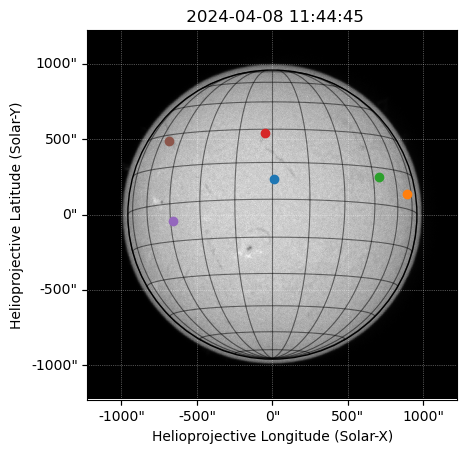

In [103]:
fig = plt.figure()
ax = fig.add_subplot(projection=map)
map.plot(axes=ax)
map.draw_limb(axes=ax, color="k")
map.draw_grid(axes=ax, color="k")

for noaa, coord in sunspot_regions:
    ax.plot_coord(coord.transform_to(map.coordinate_frame) , 'o')

[(3628, 'N08W00'),
 (3629, 'N06W69'),
 (3631, 'N11W48'),
 (3632, 'N28E04'),
 (3633, 'S07E44'),
 (3634, 'N27E54')]